In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


https://medium.com/squad-engineering/one-class-classification-for-images-with-deep-features-69182fb4c9c5

https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [ ]:
import os
import math
import pandas as pd
from glob import glob
import numpy as np
import cv2
data_path = '/content/drive/MyDrive/магистратура/realty_model/rating_system/classifier_image_only'
pic_path = os.path.join(data_path, 'pic_folder')

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from PIL import Image 
from torchvision import transforms, utils, datasets, models
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler

In [ ]:
np.random.seed(0)
torch.manual_seed(0)

In [ ]:
%matplotlib inline
sns.set_style('darkgrid')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)
root_dir = pic_path
print("The data lies here =>", root_dir)

We're using => cuda
The data lies here => /content/drive/MyDrive/магистратура/realty_model/rating_system/classifier_image_only/pic_folder


In [ ]:
import PIL
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
        transforms.ToTensor()
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()])
    }

In [ ]:
from joblib import Parallel, delayed

In [ ]:
class rating_dataset(Dataset):
    def __init__(self, dir, train=True, transform=None):
        files = []
        pattern   = "*.jpeg"
        for dir,_,file_name in os.walk(dir):
            files.extend(glob(os.path.join(dir,pattern)))
        def get_path(x, files=files):
            for i in files:
                if x in i:
                    return i
        data = pd.read_csv(os.path.join(data_path, 'merged_data.csv'))
        data = data[data['flat']!=0]
        data['file_path'] = data['file_names'].apply(get_path)
        data.dropna(inplace=True)
        self.index, self.images = zip(*list(enumerate(data['file_path'])))
        self.transform = transform
        self.index = np.array(self.index)
        # self.style_estim = np.array(data['style'])
        self.style_estim = np.array(data['normalized_style'])
        # normalized_style
        self.images = Parallel(n_jobs=30)(delayed(Image.open)(i) for _, i in tqdm(enumerate(self.images)))
        # self.images = [Image.open(i) for _, i in tqdm(enumerate(self.images))]
        # self.images = [delayed(Image.open)(i) for _, i in tqdm(enumerate(self.images))]
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, item):
        img = self.images[item]
        if self.transform:
            img = self.transform(img)
        # img = cv2.imread(img)
        style_estim = self.style_estim[item]
        return img, style_estim

In [ ]:
flat_dataset = rating_dataset(pic_path, transform=image_transforms['train'])

In [ ]:
len(flat_dataset)

953

In [ ]:
data = pd.read_csv(os.path.join(data_path, 'merged_data.csv'))

In [ ]:
data.head()

,file_names,flat,restoration,style,labeler_id,normalized_style
0,-100918699400681824.jpeg,0.0,0.0,0.0,0,-3.225
1,-100918699400681904.jpeg,1.0,2.0,7.0,0,3.775
2,-100918699417093520.jpeg,0.0,0.0,0.0,0,-3.225
3,-100918699417093744.jpeg,0.0,0.0,0.0,0,-3.225
4,-103646700382705216.jpeg,0.0,0.0,0.0,0,-3.225


In [ ]:
data = data[data['flat']!=0]

In [ ]:
data['style'] = data['style'].apply(lambda x: str(int(x)))

In [ ]:
data.groupby('style')['file_names'].count()

style
0     157
1      18
10     94
2      24
3      47
4      85
5     113
6     110
7     156
8     107
9      46
Name: file_names, dtype: int64

In [ ]:
flat_dataset_size = len(flat_dataset)
flat_dataset_indices = list(range(flat_dataset_size))

In [ ]:
np.random.shuffle(flat_dataset_indices)

In [ ]:
val_split_index = int(np.floor(0.2 * flat_dataset_size))
test_split_index = int(np.floor(0.4 * flat_dataset_size))

In [ ]:
train_idx, test_idx, val_idx = flat_dataset_indices[test_split_index:], flat_dataset_indices[val_split_index:test_split_index], flat_dataset_indices[:val_split_index]

In [ ]:
len(train_idx)

572

In [ ]:
len(test_idx)

191

In [ ]:
len(val_idx)

190

In [ ]:
dataset_sizes = {}
dataset_sizes['train'] = len(train_idx)
dataset_sizes['val'] = len(val_idx)

In [ ]:
len(flat_dataset_indices)

953

In [ ]:
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

In [ ]:
train_loader = DataLoader(dataset=flat_dataset, shuffle=False, batch_size=64, sampler=train_sampler)
val_loader = DataLoader(dataset=flat_dataset, shuffle=False, batch_size=32, sampler=valid_sampler)
test_loader = DataLoader(dataset=flat_dataset, shuffle=False, batch_size=32, sampler=test_sampler)

In [ ]:
dataloaders = {}
dataloaders['train'] = train_loader
dataloaders['val'] = val_loader

In [ ]:
model = models.resnet50(pretrained=True,)
from torch.optim.swa_utils import AveragedModel, SWALR
print(model)
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 1))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.01, weight_decay=1e-2)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
# swa_scheduler = SWALR(optimizer, swa_lr=0.05)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
import time
import copy
def train_model(model, criterion, optimizer, scheduler, num_epochs=40):
    since = time.time()
    train_loss = []
    val_loss = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.float().to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs).float()
                    loss = criterion(outputs, labels.unsqueeze(1))

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                # running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            # epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase=='train':
                train_loss.append(epoch_loss)
            else:
                val_loss.append(epoch_loss)
            print('{} Loss: {:.4f} '.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    print('hello')
    model.load_state_dict(best_model_wts)
    print('buy')
    return model, train_loss, val_loss

In [ ]:
model_conv, train_loss, val_loss = train_model(model, criterion, optimizer,
                         swa_scheduler, num_epochs=40)

Epoch 0/39
----------
train Loss: 490.3893 
val Loss: 85.6195 

Epoch 1/39
----------
train Loss: 36.8817 
val Loss: 13.5762 

Epoch 2/39
----------
train Loss: 13.0194 
val Loss: 6.7991 

Epoch 3/39
----------
train Loss: 8.1783 
val Loss: 7.1017 

Epoch 4/39
----------
train Loss: 6.7836 
val Loss: 4.9152 

Epoch 5/39
----------
train Loss: 5.1916 
val Loss: 3.5365 

Epoch 6/39
----------
train Loss: 4.6521 
val Loss: 5.0647 

Epoch 7/39
----------
train Loss: 4.8643 
val Loss: 4.6553 

Epoch 8/39
----------
train Loss: 4.8092 
val Loss: 3.5941 

Epoch 9/39
----------
train Loss: 4.4528 
val Loss: 4.3535 

Epoch 10/39
----------
train Loss: 4.4034 
val Loss: 5.2680 

Epoch 11/39
----------
train Loss: 4.3519 
val Loss: 3.0930 

Epoch 12/39
----------
train Loss: 4.3930 
val Loss: 3.6537 

Epoch 13/39
----------
train Loss: 4.3055 
val Loss: 3.1984 

Epoch 14/39
----------
train Loss: 4.1600 
val Loss: 3.4336 

Epoch 15/39
----------
train Loss: 3.8814 
val Loss: 3.4513 

Epoch 16/39


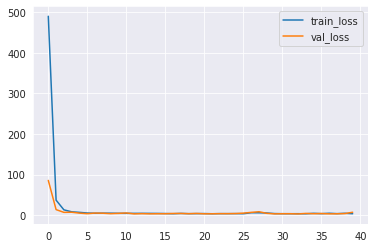

In [ ]:
plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.legend()
plt.show()

In [ ]:
import plotly.express as px
a =1
b = -1
fig = px.line(x=list(range(40)[a:b]), y=train_loss[a:b], labels={'y':'losses', 'x':'epochs'})
fig.add_scatter(x=list(range(40)[a:b]), y=val_loss[a:b], mode='lines')
# fig = px.line(x=list(range(40)), y=val_loss)
fig.show()

In [ ]:
from torch.autograd import Variable
def predict_image(image, model):
    image_tensor = image_transforms["test"](image)
    # image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [ ]:
def get_random_images(num=None):
    data = flat_dataset_test
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    if num is None:
        idx = indices[:]
        num = len(indices)
    else:
        idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

In [ ]:
criterion = nn.L1Loss()
losses = []
for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.float().to(device)
    with torch.set_grad_enabled(False):
        outputs = model(inputs).float()
        loss = criterion(outputs, labels.unsqueeze(1))
        losses.append(loss.cpu().numpy())
print(sum(losses)/len(losses))

1.5425451397895813


In [ ]:
# os.path.join(data_path, 'x_train.npy')
torch.save(model_conv.state_dict(), os.path.join(data_path, 'resnet50_pretrained_image_regression.pth'))